In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet50_vicreg_ce"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "1:4"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 333290 images
Dataset type val label type: species


Loaded 43293 images
Dataset type test label type: species


Loaded 43520 images
Dataset type test label type: species


Loaded 5270 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1:4 drehrsxe


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-drehrsxe:best, 314.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.6


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_ftr = []
trn_emb = []
trn_lgt = []
trn_tgt = []

val_inp = []
val_ftr = []
val_emb = []
val_lgt = []
val_tgt = []

ind_inp = []
ind_ftr = []
ind_emb = []
ind_lgt = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_ftr = []
    ood_emb = []
    ood_lgt = []
    ood_tgt = []

rnd_inp = []
rnd_ftr = []
rnd_emb = []
rnd_lgt = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_ftr.extend(ftr.detach().cpu().numpy())
    trn_emb.extend(emb.detach().cpu().numpy())
    trn_lgt.extend(lgt.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_ftr.extend(ftr.detach().cpu().numpy())
    val_emb.extend(emb.detach().cpu().numpy())
    val_lgt.extend(lgt.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_ftr.extend(ftr.detach().cpu().numpy())
    ind_emb.extend(emb.detach().cpu().numpy())
    ind_lgt.extend(lgt.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        ftr, emb, lgt = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_ftr.extend(ftr.detach().cpu().numpy())
        ood_emb.extend(emb.detach().cpu().numpy())
        ood_lgt.extend(lgt.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    ftr, emb, lgt = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_ftr.extend(ftr.detach().cpu().numpy())
    rnd_emb.extend(emb.detach().cpu().numpy())
    rnd_lgt.extend(lgt.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                                                                     | 0/5208 [00:00<?, ?it/s]

  0%|                                                                                                                                                                             | 1/5208 [00:00<49:06,  1.77it/s]

  0%|▎                                                                                                                                                                           | 10/5208 [00:00<04:29, 19.27it/s]

  0%|▋                                                                                                                                                                           | 19/5208 [00:00<02:30, 34.44it/s]

  1%|▉                                                                                                                                                                           | 29/5208 [00:00<01:46, 48.78it/s]

  1%|█▎                                                                                                                                                                          | 39/5208 [00:00<01:24, 60.95it/s]

  1%|█▌                                                                                                                                                                          | 49/5208 [00:01<01:13, 70.51it/s]

  1%|█▉                                                                                                                                                                          | 59/5208 [00:01<01:06, 77.71it/s]

  1%|██▎                                                                                                                                                                         | 69/5208 [00:01<01:01, 83.08it/s]

  2%|██▌                                                                                                                                                                         | 79/5208 [00:01<00:59, 86.24it/s]

  2%|██▉                                                                                                                                                                         | 89/5208 [00:01<00:57, 88.51it/s]

  2%|███▎                                                                                                                                                                        | 99/5208 [00:01<00:56, 90.29it/s]

  2%|███▌                                                                                                                                                                       | 109/5208 [00:01<00:55, 91.42it/s]

  2%|███▉                                                                                                                                                                       | 119/5208 [00:01<00:55, 92.07it/s]

  2%|████▏                                                                                                                                                                      | 129/5208 [00:01<00:54, 92.58it/s]

  3%|████▌                                                                                                                                                                      | 139/5208 [00:02<00:54, 92.77it/s]

  3%|████▉                                                                                                                                                                      | 149/5208 [00:02<00:54, 92.98it/s]

  3%|█████▏                                                                                                                                                                     | 159/5208 [00:02<00:54, 93.33it/s]

  3%|█████▌                                                                                                                                                                     | 169/5208 [00:02<00:53, 93.87it/s]

  3%|█████▉                                                                                                                                                                     | 179/5208 [00:02<00:53, 93.88it/s]

  4%|██████▏                                                                                                                                                                    | 189/5208 [00:02<00:53, 93.71it/s]

  4%|██████▌                                                                                                                                                                    | 199/5208 [00:02<00:53, 93.72it/s]

  4%|██████▊                                                                                                                                                                    | 209/5208 [00:02<00:53, 93.73it/s]

  4%|███████▏                                                                                                                                                                   | 219/5208 [00:02<00:53, 93.62it/s]

  4%|███████▌                                                                                                                                                                   | 229/5208 [00:03<00:53, 93.39it/s]

  5%|███████▊                                                                                                                                                                   | 239/5208 [00:03<00:53, 93.49it/s]

  5%|████████▏                                                                                                                                                                  | 249/5208 [00:03<00:52, 93.64it/s]

  5%|████████▌                                                                                                                                                                  | 259/5208 [00:03<00:52, 94.17it/s]

  5%|████████▊                                                                                                                                                                  | 269/5208 [00:03<00:52, 94.50it/s]

  5%|█████████▏                                                                                                                                                                 | 279/5208 [00:03<00:52, 94.63it/s]

  6%|█████████▍                                                                                                                                                                 | 289/5208 [00:03<00:52, 93.10it/s]

  6%|█████████▊                                                                                                                                                                 | 299/5208 [00:03<00:53, 90.97it/s]

  6%|██████████▏                                                                                                                                                                | 309/5208 [00:03<00:54, 89.63it/s]

  6%|██████████▍                                                                                                                                                                | 318/5208 [00:03<00:55, 88.66it/s]

  6%|██████████▋                                                                                                                                                                | 327/5208 [00:04<00:55, 88.02it/s]

  6%|███████████                                                                                                                                                                | 336/5208 [00:04<00:55, 87.49it/s]

  7%|███████████▎                                                                                                                                                               | 345/5208 [00:04<00:55, 87.27it/s]

  7%|███████████▌                                                                                                                                                               | 354/5208 [00:04<00:55, 87.12it/s]

  7%|███████████▉                                                                                                                                                               | 363/5208 [00:04<00:55, 86.91it/s]

  7%|████████████▏                                                                                                                                                              | 372/5208 [00:04<00:55, 86.74it/s]

  7%|████████████▌                                                                                                                                                              | 381/5208 [00:04<00:55, 86.81it/s]

  7%|████████████▊                                                                                                                                                              | 390/5208 [00:04<00:55, 86.76it/s]

  8%|█████████████                                                                                                                                                              | 399/5208 [00:04<00:55, 86.78it/s]

  8%|█████████████▍                                                                                                                                                             | 408/5208 [00:05<00:55, 86.82it/s]

  8%|█████████████▋                                                                                                                                                             | 417/5208 [00:05<00:55, 86.80it/s]

  8%|█████████████▉                                                                                                                                                             | 426/5208 [00:05<00:55, 86.82it/s]

  8%|██████████████▎                                                                                                                                                            | 435/5208 [00:05<00:55, 86.63it/s]

  9%|██████████████▌                                                                                                                                                            | 444/5208 [00:05<00:55, 86.47it/s]

  9%|██████████████▊                                                                                                                                                            | 453/5208 [00:05<00:56, 84.74it/s]

  9%|███████████████▏                                                                                                                                                           | 462/5208 [00:05<00:55, 85.08it/s]

  9%|███████████████▍                                                                                                                                                           | 471/5208 [00:05<00:55, 85.52it/s]

  9%|███████████████▊                                                                                                                                                           | 480/5208 [00:05<00:55, 85.86it/s]

  9%|████████████████                                                                                                                                                           | 489/5208 [00:05<00:54, 86.09it/s]

 10%|████████████████▎                                                                                                                                                          | 498/5208 [00:06<00:54, 86.20it/s]

 10%|████████████████▋                                                                                                                                                          | 507/5208 [00:06<00:54, 86.27it/s]

 10%|████████████████▉                                                                                                                                                          | 516/5208 [00:06<00:54, 86.39it/s]

 10%|█████████████████▏                                                                                                                                                         | 525/5208 [00:06<00:54, 86.45it/s]

 10%|█████████████████▌                                                                                                                                                         | 534/5208 [00:06<00:53, 86.58it/s]

 10%|█████████████████▊                                                                                                                                                         | 543/5208 [00:06<00:53, 86.50it/s]

 11%|██████████████████                                                                                                                                                         | 552/5208 [00:06<00:53, 86.68it/s]

 11%|██████████████████▍                                                                                                                                                        | 561/5208 [00:06<00:53, 86.84it/s]

 11%|██████████████████▋                                                                                                                                                        | 570/5208 [00:06<00:53, 86.91it/s]

 11%|███████████████████                                                                                                                                                        | 579/5208 [00:07<00:53, 86.89it/s]

 11%|███████████████████▎                                                                                                                                                       | 588/5208 [00:07<00:53, 86.94it/s]

 11%|███████████████████▌                                                                                                                                                       | 597/5208 [00:07<00:53, 86.92it/s]

 12%|███████████████████▉                                                                                                                                                       | 606/5208 [00:07<00:52, 86.99it/s]

 12%|████████████████████▏                                                                                                                                                      | 615/5208 [00:07<00:52, 86.96it/s]

 12%|████████████████████▍                                                                                                                                                      | 624/5208 [00:07<00:52, 86.84it/s]

 12%|████████████████████▊                                                                                                                                                      | 633/5208 [00:07<00:52, 86.81it/s]

 12%|█████████████████████                                                                                                                                                      | 642/5208 [00:07<00:52, 86.89it/s]

 12%|█████████████████████▍                                                                                                                                                     | 651/5208 [00:07<00:52, 86.78it/s]

 13%|█████████████████████▋                                                                                                                                                     | 660/5208 [00:07<00:52, 86.80it/s]

 13%|█████████████████████▉                                                                                                                                                     | 669/5208 [00:08<00:52, 86.60it/s]

 13%|██████████████████████▎                                                                                                                                                    | 678/5208 [00:08<00:52, 86.63it/s]

 13%|██████████████████████▌                                                                                                                                                    | 687/5208 [00:08<00:52, 86.76it/s]

 13%|██████████████████████▊                                                                                                                                                    | 696/5208 [00:08<00:51, 86.88it/s]

 14%|███████████████████████▏                                                                                                                                                   | 706/5208 [00:08<00:50, 89.82it/s]

 14%|███████████████████████▌                                                                                                                                                   | 716/5208 [00:08<00:48, 92.34it/s]

 14%|███████████████████████▊                                                                                                                                                   | 726/5208 [00:08<00:47, 94.22it/s]

 14%|████████████████████████▏                                                                                                                                                  | 736/5208 [00:08<00:46, 95.40it/s]

 14%|████████████████████████▍                                                                                                                                                  | 746/5208 [00:08<00:46, 96.36it/s]

 15%|████████████████████████▊                                                                                                                                                  | 756/5208 [00:08<00:45, 96.94it/s]

 15%|█████████████████████████▏                                                                                                                                                 | 766/5208 [00:09<00:45, 97.56it/s]

 15%|█████████████████████████▍                                                                                                                                                 | 776/5208 [00:09<00:45, 97.62it/s]

 15%|█████████████████████████▊                                                                                                                                                 | 786/5208 [00:09<00:45, 97.84it/s]

 15%|██████████████████████████▏                                                                                                                                                | 796/5208 [00:09<00:45, 97.90it/s]

 15%|██████████████████████████▍                                                                                                                                                | 806/5208 [00:09<00:44, 98.17it/s]

 16%|██████████████████████████▊                                                                                                                                                | 816/5208 [00:09<00:44, 98.34it/s]

 16%|███████████████████████████                                                                                                                                                | 826/5208 [00:09<00:44, 98.20it/s]

 16%|███████████████████████████▍                                                                                                                                               | 836/5208 [00:09<00:44, 98.07it/s]

 16%|███████████████████████████▊                                                                                                                                               | 846/5208 [00:09<00:44, 98.18it/s]

 16%|████████████████████████████                                                                                                                                               | 856/5208 [00:09<00:44, 98.22it/s]

 17%|████████████████████████████▍                                                                                                                                              | 866/5208 [00:10<00:44, 98.10it/s]

 17%|████████████████████████████▊                                                                                                                                              | 876/5208 [00:10<00:44, 98.11it/s]

 17%|█████████████████████████████                                                                                                                                              | 886/5208 [00:10<00:44, 98.12it/s]

 17%|█████████████████████████████▍                                                                                                                                             | 896/5208 [00:10<00:43, 98.08it/s]

 17%|█████████████████████████████▋                                                                                                                                             | 906/5208 [00:10<00:43, 98.11it/s]

 18%|██████████████████████████████                                                                                                                                             | 916/5208 [00:10<00:43, 98.15it/s]

 18%|██████████████████████████████▍                                                                                                                                            | 926/5208 [00:10<00:43, 98.16it/s]

 18%|██████████████████████████████▋                                                                                                                                            | 936/5208 [00:10<00:43, 98.30it/s]

 18%|███████████████████████████████                                                                                                                                            | 946/5208 [00:10<00:43, 98.37it/s]

 18%|███████████████████████████████▍                                                                                                                                           | 956/5208 [00:10<00:43, 98.36it/s]

 19%|███████████████████████████████▋                                                                                                                                           | 966/5208 [00:11<00:43, 98.20it/s]

 19%|████████████████████████████████                                                                                                                                           | 976/5208 [00:11<00:43, 98.29it/s]

 19%|████████████████████████████████▎                                                                                                                                          | 986/5208 [00:11<00:42, 98.31it/s]

 19%|████████████████████████████████▋                                                                                                                                          | 996/5208 [00:11<00:42, 98.33it/s]

 19%|████████████████████████████████▊                                                                                                                                         | 1006/5208 [00:11<00:42, 98.40it/s]

 20%|█████████████████████████████████▏                                                                                                                                        | 1016/5208 [00:11<00:42, 98.47it/s]

 20%|█████████████████████████████████▍                                                                                                                                        | 1026/5208 [00:11<00:42, 98.68it/s]

 20%|█████████████████████████████████▊                                                                                                                                        | 1036/5208 [00:11<00:42, 98.66it/s]

 20%|██████████████████████████████████▏                                                                                                                                       | 1046/5208 [00:11<00:42, 98.33it/s]

 20%|██████████████████████████████████▍                                                                                                                                       | 1056/5208 [00:12<00:42, 98.44it/s]

 20%|██████████████████████████████████▊                                                                                                                                       | 1066/5208 [00:12<00:42, 98.27it/s]

 21%|███████████████████████████████████                                                                                                                                       | 1076/5208 [00:12<00:42, 97.75it/s]

 21%|███████████████████████████████████▍                                                                                                                                      | 1086/5208 [00:12<00:42, 97.53it/s]

 21%|███████████████████████████████████▊                                                                                                                                      | 1096/5208 [00:12<00:42, 97.21it/s]

 21%|████████████████████████████████████                                                                                                                                      | 1106/5208 [00:12<00:42, 97.12it/s]

 21%|████████████████████████████████████▍                                                                                                                                     | 1116/5208 [00:12<00:42, 97.17it/s]

 22%|████████████████████████████████████▊                                                                                                                                     | 1126/5208 [00:12<00:42, 97.00it/s]

 22%|█████████████████████████████████████                                                                                                                                     | 1136/5208 [00:12<00:41, 96.98it/s]

 22%|█████████████████████████████████████▍                                                                                                                                    | 1146/5208 [00:12<00:41, 96.96it/s]

 22%|█████████████████████████████████████▋                                                                                                                                    | 1156/5208 [00:13<00:41, 96.97it/s]

 22%|██████████████████████████████████████                                                                                                                                    | 1166/5208 [00:13<00:41, 96.98it/s]

 23%|██████████████████████████████████████▍                                                                                                                                   | 1176/5208 [00:13<00:41, 96.67it/s]

 23%|██████████████████████████████████████▋                                                                                                                                   | 1186/5208 [00:13<00:41, 96.72it/s]

 23%|███████████████████████████████████████                                                                                                                                   | 1196/5208 [00:13<00:41, 96.86it/s]

 23%|███████████████████████████████████████▎                                                                                                                                  | 1206/5208 [00:13<00:41, 96.76it/s]

 23%|███████████████████████████████████████▋                                                                                                                                  | 1216/5208 [00:13<00:41, 96.70it/s]

 24%|████████████████████████████████████████                                                                                                                                  | 1226/5208 [00:13<00:41, 96.74it/s]

 24%|████████████████████████████████████████▎                                                                                                                                 | 1236/5208 [00:13<00:41, 96.75it/s]

 24%|████████████████████████████████████████▋                                                                                                                                 | 1246/5208 [00:13<00:40, 96.88it/s]

 24%|████████████████████████████████████████▉                                                                                                                                 | 1256/5208 [00:14<00:40, 96.92it/s]

 24%|█████████████████████████████████████████▎                                                                                                                                | 1266/5208 [00:14<00:40, 96.93it/s]

 25%|█████████████████████████████████████████▋                                                                                                                                | 1276/5208 [00:14<00:40, 96.91it/s]

 25%|█████████████████████████████████████████▉                                                                                                                                | 1286/5208 [00:14<00:40, 96.81it/s]

 25%|██████████████████████████████████████████▎                                                                                                                               | 1296/5208 [00:14<00:40, 96.65it/s]

 25%|██████████████████████████████████████████▋                                                                                                                               | 1306/5208 [00:14<00:40, 96.81it/s]

 25%|██████████████████████████████████████████▉                                                                                                                               | 1316/5208 [00:14<00:40, 96.67it/s]

 25%|███████████████████████████████████████████▎                                                                                                                              | 1326/5208 [00:14<00:40, 96.90it/s]

 26%|███████████████████████████████████████████▌                                                                                                                              | 1336/5208 [00:14<00:39, 97.02it/s]

 26%|███████████████████████████████████████████▉                                                                                                                              | 1346/5208 [00:15<00:39, 96.89it/s]

 26%|████████████████████████████████████████████▎                                                                                                                             | 1356/5208 [00:15<00:39, 96.91it/s]

 26%|████████████████████████████████████████████▌                                                                                                                             | 1366/5208 [00:15<00:39, 96.85it/s]

 26%|████████████████████████████████████████████▉                                                                                                                             | 1376/5208 [00:15<00:39, 96.79it/s]

 27%|█████████████████████████████████████████████▏                                                                                                                            | 1386/5208 [00:15<00:39, 96.73it/s]

 27%|█████████████████████████████████████████████▌                                                                                                                            | 1396/5208 [00:15<00:39, 96.62it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                            | 1406/5208 [00:15<00:39, 96.67it/s]

 27%|██████████████████████████████████████████████▏                                                                                                                           | 1416/5208 [00:15<00:39, 96.75it/s]

 27%|██████████████████████████████████████████████▌                                                                                                                           | 1426/5208 [00:15<00:39, 96.76it/s]

 28%|██████████████████████████████████████████████▊                                                                                                                           | 1436/5208 [00:15<00:38, 96.84it/s]

 28%|███████████████████████████████████████████████▏                                                                                                                          | 1446/5208 [00:16<00:38, 96.88it/s]

 28%|███████████████████████████████████████████████▌                                                                                                                          | 1456/5208 [00:16<00:38, 96.89it/s]

 28%|███████████████████████████████████████████████▊                                                                                                                          | 1466/5208 [00:16<00:38, 96.63it/s]

 28%|████████████████████████████████████████████████▏                                                                                                                         | 1476/5208 [00:16<00:38, 96.71it/s]

 29%|████████████████████████████████████████████████▌                                                                                                                         | 1486/5208 [00:16<00:38, 96.49it/s]

 29%|████████████████████████████████████████████████▊                                                                                                                         | 1496/5208 [00:16<00:38, 96.65it/s]

 29%|█████████████████████████████████████████████████▏                                                                                                                        | 1506/5208 [00:16<00:38, 96.74it/s]

 29%|█████████████████████████████████████████████████▍                                                                                                                        | 1516/5208 [00:16<00:38, 96.79it/s]

 29%|█████████████████████████████████████████████████▊                                                                                                                        | 1526/5208 [00:16<00:38, 96.82it/s]

 29%|██████████████████████████████████████████████████▏                                                                                                                       | 1536/5208 [00:16<00:37, 96.87it/s]

 30%|██████████████████████████████████████████████████▍                                                                                                                       | 1546/5208 [00:17<00:37, 96.85it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                       | 1556/5208 [00:17<00:37, 96.79it/s]

 30%|███████████████████████████████████████████████████                                                                                                                       | 1566/5208 [00:17<00:37, 96.85it/s]

 30%|███████████████████████████████████████████████████▍                                                                                                                      | 1576/5208 [00:17<00:37, 96.84it/s]

 30%|███████████████████████████████████████████████████▊                                                                                                                      | 1586/5208 [00:17<00:37, 96.88it/s]

 31%|████████████████████████████████████████████████████                                                                                                                      | 1596/5208 [00:17<00:37, 96.95it/s]

 31%|████████████████████████████████████████████████████▍                                                                                                                     | 1606/5208 [00:17<00:37, 97.03it/s]

 31%|████████████████████████████████████████████████████▋                                                                                                                     | 1616/5208 [00:17<00:37, 97.06it/s]

 31%|█████████████████████████████████████████████████████                                                                                                                     | 1626/5208 [00:17<00:36, 97.06it/s]

 31%|█████████████████████████████████████████████████████▍                                                                                                                    | 1636/5208 [00:18<00:36, 96.89it/s]

 32%|█████████████████████████████████████████████████████▋                                                                                                                    | 1646/5208 [00:18<00:36, 97.07it/s]

 32%|██████████████████████████████████████████████████████                                                                                                                    | 1656/5208 [00:18<00:36, 97.11it/s]

 32%|██████████████████████████████████████████████████████▍                                                                                                                   | 1666/5208 [00:18<00:36, 96.75it/s]

 32%|██████████████████████████████████████████████████████▋                                                                                                                   | 1676/5208 [00:18<00:36, 96.74it/s]

 32%|███████████████████████████████████████████████████████                                                                                                                   | 1686/5208 [00:18<00:36, 96.74it/s]

 33%|███████████████████████████████████████████████████████▎                                                                                                                  | 1696/5208 [00:18<00:36, 96.88it/s]

 33%|███████████████████████████████████████████████████████▋                                                                                                                  | 1706/5208 [00:18<00:36, 97.19it/s]

 33%|████████████████████████████████████████████████████████                                                                                                                  | 1716/5208 [00:18<00:35, 97.54it/s]

 33%|████████████████████████████████████████████████████████▎                                                                                                                 | 1726/5208 [00:18<00:35, 97.95it/s]

 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 1736/5208 [00:19<00:35, 98.26it/s]

 34%|████████████████████████████████████████████████████████▉                                                                                                                 | 1746/5208 [00:19<00:35, 98.40it/s]

 34%|█████████████████████████████████████████████████████████▎                                                                                                                | 1756/5208 [00:19<00:35, 98.38it/s]

 34%|█████████████████████████████████████████████████████████▋                                                                                                                | 1766/5208 [00:19<00:35, 98.05it/s]

 34%|█████████████████████████████████████████████████████████▉                                                                                                                | 1776/5208 [00:19<00:35, 97.98it/s]

 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 1786/5208 [00:19<00:34, 97.99it/s]

 34%|██████████████████████████████████████████████████████████▋                                                                                                               | 1796/5208 [00:19<00:34, 98.03it/s]

 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 1806/5208 [00:19<00:34, 97.88it/s]

 35%|███████████████████████████████████████████████████████████▎                                                                                                              | 1816/5208 [00:19<00:34, 97.87it/s]

 35%|███████████████████████████████████████████████████████████▌                                                                                                              | 1826/5208 [00:19<00:34, 97.94it/s]

 35%|███████████████████████████████████████████████████████████▉                                                                                                              | 1836/5208 [00:20<00:34, 97.91it/s]

 35%|████████████████████████████████████████████████████████████▎                                                                                                             | 1846/5208 [00:20<00:34, 97.83it/s]

 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 1856/5208 [00:20<00:34, 97.86it/s]

 36%|████████████████████████████████████████████████████████████▉                                                                                                             | 1866/5208 [00:20<00:34, 97.89it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 1876/5208 [00:20<00:34, 97.56it/s]

 36%|█████████████████████████████████████████████████████████████▌                                                                                                            | 1886/5208 [00:20<00:34, 97.52it/s]

 36%|█████████████████████████████████████████████████████████████▉                                                                                                            | 1896/5208 [00:20<00:33, 97.56it/s]

 37%|██████████████████████████████████████████████████████████████▏                                                                                                           | 1906/5208 [00:20<00:33, 97.62it/s]

 37%|██████████████████████████████████████████████████████████████▌                                                                                                           | 1916/5208 [00:20<00:33, 97.74it/s]

 37%|██████████████████████████████████████████████████████████████▊                                                                                                           | 1926/5208 [00:20<00:33, 98.03it/s]

 37%|███████████████████████████████████████████████████████████████▏                                                                                                          | 1936/5208 [00:21<00:33, 98.41it/s]

 37%|███████████████████████████████████████████████████████████████▌                                                                                                          | 1946/5208 [00:21<00:33, 98.61it/s]

 38%|███████████████████████████████████████████████████████████████▊                                                                                                          | 1956/5208 [00:21<00:32, 98.76it/s]

 38%|████████████████████████████████████████████████████████████████▏                                                                                                         | 1966/5208 [00:21<00:32, 98.81it/s]

 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 1976/5208 [00:21<00:32, 98.90it/s]

 38%|████████████████████████████████████████████████████████████████▊                                                                                                         | 1986/5208 [00:21<00:32, 98.78it/s]

 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 1996/5208 [00:21<00:32, 98.86it/s]

 39%|█████████████████████████████████████████████████████████████████▍                                                                                                        | 2006/5208 [00:21<00:32, 99.00it/s]

 39%|█████████████████████████████████████████████████████████████████▊                                                                                                        | 2016/5208 [00:21<00:32, 99.03it/s]

 39%|██████████████████████████████████████████████████████████████████▏                                                                                                       | 2026/5208 [00:21<00:32, 98.99it/s]

 39%|██████████████████████████████████████████████████████████████████▍                                                                                                       | 2036/5208 [00:22<00:32, 98.93it/s]

 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 2046/5208 [00:22<00:31, 98.92it/s]

 39%|███████████████████████████████████████████████████████████████████                                                                                                       | 2056/5208 [00:22<00:31, 98.63it/s]

 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 2066/5208 [00:22<00:31, 98.65it/s]

 40%|███████████████████████████████████████████████████████████████████▊                                                                                                      | 2076/5208 [00:22<00:31, 98.95it/s]

 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 2086/5208 [00:22<00:31, 98.89it/s]

 40%|████████████████████████████████████████████████████████████████████▍                                                                                                     | 2096/5208 [00:22<00:31, 98.84it/s]

 40%|████████████████████████████████████████████████████████████████████▋                                                                                                     | 2106/5208 [00:22<00:31, 98.53it/s]

 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 2116/5208 [00:22<00:31, 98.66it/s]

 41%|█████████████████████████████████████████████████████████████████████▍                                                                                                    | 2126/5208 [00:22<00:31, 98.96it/s]

 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 2136/5208 [00:23<00:31, 98.73it/s]

 41%|██████████████████████████████████████████████████████████████████████                                                                                                    | 2146/5208 [00:23<00:30, 98.85it/s]

 41%|██████████████████████████████████████████████████████████████████████▍                                                                                                   | 2156/5208 [00:23<00:30, 98.79it/s]

 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 2166/5208 [00:23<00:30, 98.88it/s]

 42%|███████████████████████████████████████████████████████████████████████                                                                                                   | 2176/5208 [00:23<00:30, 98.85it/s]

 42%|███████████████████████████████████████████████████████████████████████▎                                                                                                  | 2186/5208 [00:23<00:30, 97.96it/s]

 42%|███████████████████████████████████████████████████████████████████████▋                                                                                                  | 2196/5208 [00:23<00:30, 97.54it/s]

 42%|████████████████████████████████████████████████████████████████████████                                                                                                  | 2206/5208 [00:23<00:30, 96.96it/s]

 43%|████████████████████████████████████████████████████████████████████████▎                                                                                                 | 2216/5208 [00:23<00:30, 96.65it/s]

 43%|████████████████████████████████████████████████████████████████████████▋                                                                                                 | 2226/5208 [00:24<00:30, 96.47it/s]

 43%|████████████████████████████████████████████████████████████████████████▉                                                                                                 | 2236/5208 [00:24<00:30, 96.53it/s]

 43%|█████████████████████████████████████████████████████████████████████████▎                                                                                                | 2246/5208 [00:24<00:30, 96.32it/s]

 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 2256/5208 [00:24<00:30, 96.28it/s]

 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                                | 2266/5208 [00:24<00:30, 96.28it/s]

 44%|██████████████████████████████████████████████████████████████████████████▎                                                                                               | 2276/5208 [00:24<00:30, 96.32it/s]

 44%|██████████████████████████████████████████████████████████████████████████▌                                                                                               | 2286/5208 [00:24<00:30, 96.20it/s]

 44%|██████████████████████████████████████████████████████████████████████████▉                                                                                               | 2296/5208 [00:24<00:30, 96.07it/s]

 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 2306/5208 [00:24<00:30, 96.09it/s]

 44%|███████████████████████████████████████████████████████████████████████████▌                                                                                              | 2316/5208 [00:24<00:30, 96.24it/s]

 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 2326/5208 [00:25<00:30, 94.60it/s]

 45%|████████████████████████████████████████████████████████████████████████████▎                                                                                             | 2336/5208 [00:25<00:30, 94.91it/s]

 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 2346/5208 [00:25<00:30, 95.21it/s]

 45%|████████████████████████████████████████████████████████████████████████████▉                                                                                             | 2356/5208 [00:25<00:29, 95.46it/s]

 45%|█████████████████████████████████████████████████████████████████████████████▏                                                                                            | 2366/5208 [00:25<00:29, 95.58it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▌                                                                                            | 2376/5208 [00:25<00:30, 93.17it/s]

 46%|█████████████████████████████████████████████████████████████████████████████▉                                                                                            | 2386/5208 [00:25<00:30, 91.28it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 2396/5208 [00:25<00:31, 90.02it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▌                                                                                           | 2406/5208 [00:25<00:31, 89.22it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 2415/5208 [00:26<00:31, 88.68it/s]

 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 2424/5208 [00:26<00:31, 88.30it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▍                                                                                          | 2433/5208 [00:26<00:31, 87.97it/s]

 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 2442/5208 [00:26<00:31, 87.78it/s]

 47%|████████████████████████████████████████████████████████████████████████████████                                                                                          | 2451/5208 [00:26<00:31, 87.64it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                         | 2460/5208 [00:26<00:31, 87.45it/s]

 47%|████████████████████████████████████████████████████████████████████████████████▌                                                                                         | 2469/5208 [00:26<00:31, 87.27it/s]

 48%|████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 2478/5208 [00:26<00:31, 87.19it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 2488/5208 [00:26<00:30, 90.30it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 2498/5208 [00:26<00:29, 92.86it/s]

 48%|█████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 2508/5208 [00:27<00:28, 94.60it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 2518/5208 [00:27<00:28, 95.73it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                       | 2528/5208 [00:27<00:27, 96.59it/s]

 49%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 2538/5208 [00:27<00:27, 97.25it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 2548/5208 [00:27<00:27, 97.70it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 2558/5208 [00:27<00:27, 97.81it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 2568/5208 [00:27<00:26, 97.98it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 2578/5208 [00:27<00:26, 98.30it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 2588/5208 [00:27<00:26, 98.44it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 2598/5208 [00:27<00:26, 98.46it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                    | 2608/5208 [00:28<00:26, 98.47it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 2618/5208 [00:28<00:26, 98.55it/s]

 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 2628/5208 [00:28<00:26, 98.62it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████                                                                                    | 2638/5208 [00:28<00:26, 98.55it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▍                                                                                   | 2648/5208 [00:28<00:26, 98.43it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 2658/5208 [00:28<00:25, 98.44it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████                                                                                   | 2668/5208 [00:28<00:25, 98.25it/s]

 51%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 2678/5208 [00:28<00:25, 98.48it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 2688/5208 [00:28<00:25, 98.42it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████                                                                                  | 2698/5208 [00:29<00:25, 98.58it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 2708/5208 [00:29<00:25, 98.61it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▋                                                                                 | 2718/5208 [00:29<00:25, 98.63it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 2728/5208 [00:29<00:25, 98.68it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 2738/5208 [00:29<00:25, 98.74it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 2748/5208 [00:29<00:24, 98.70it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 2758/5208 [00:29<00:24, 98.76it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                               | 2768/5208 [00:29<00:24, 98.66it/s]

 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 2778/5208 [00:29<00:24, 98.71it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████                                                                               | 2788/5208 [00:29<00:24, 98.84it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                              | 2798/5208 [00:30<00:24, 98.95it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                              | 2808/5208 [00:30<00:24, 98.66it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 2818/5208 [00:30<00:24, 98.52it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 2828/5208 [00:30<00:24, 98.58it/s]

 54%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                                             | 2838/5208 [00:30<00:24, 98.73it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 2848/5208 [00:30<00:23, 98.73it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 2858/5208 [00:30<00:23, 98.84it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 2868/5208 [00:30<00:23, 98.76it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                                            | 2878/5208 [00:30<00:23, 98.75it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 2888/5208 [00:30<00:23, 97.86it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                           | 2898/5208 [00:31<00:23, 97.29it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 2908/5208 [00:31<00:23, 97.06it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 2918/5208 [00:31<00:23, 96.82it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 2928/5208 [00:31<00:23, 96.52it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 2938/5208 [00:31<00:23, 96.47it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 2948/5208 [00:31<00:23, 96.56it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                         | 2958/5208 [00:31<00:23, 96.46it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 2968/5208 [00:31<00:23, 96.25it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 2978/5208 [00:31<00:23, 96.25it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 2988/5208 [00:31<00:23, 96.30it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 2998/5208 [00:32<00:22, 96.42it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 3008/5208 [00:32<00:23, 92.95it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 3018/5208 [00:32<00:24, 91.01it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                       | 3028/5208 [00:32<00:24, 89.71it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 3037/5208 [00:32<00:24, 89.05it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 3046/5208 [00:32<00:24, 88.54it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 3055/5208 [00:32<00:24, 88.20it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 3064/5208 [00:32<00:24, 87.86it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 3073/5208 [00:32<00:24, 87.71it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                     | 3082/5208 [00:33<00:24, 87.56it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 3091/5208 [00:33<00:24, 87.49it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 3100/5208 [00:33<00:24, 87.47it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 3109/5208 [00:33<00:24, 87.32it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 3118/5208 [00:33<00:23, 87.16it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 3128/5208 [00:33<00:23, 88.80it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3138/5208 [00:33<00:22, 91.63it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 3148/5208 [00:33<00:21, 93.75it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                   | 3158/5208 [00:33<00:21, 95.32it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 3168/5208 [00:33<00:21, 96.46it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 3178/5208 [00:34<00:20, 97.26it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 3188/5208 [00:34<00:20, 97.76it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 3198/5208 [00:34<00:20, 98.24it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 3208/5208 [00:34<00:20, 98.36it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                 | 3218/5208 [00:34<00:20, 98.46it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 3228/5208 [00:34<00:20, 98.47it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                | 3238/5208 [00:34<00:20, 97.83it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 3248/5208 [00:34<00:19, 98.07it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 3258/5208 [00:34<00:19, 98.28it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 3268/5208 [00:34<00:19, 98.43it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 3278/5208 [00:35<00:19, 98.62it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 3288/5208 [00:35<00:19, 98.70it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 3298/5208 [00:35<00:19, 98.91it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 3308/5208 [00:35<00:19, 98.93it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                             | 3318/5208 [00:35<00:19, 98.78it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                             | 3328/5208 [00:35<00:19, 98.87it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 3338/5208 [00:35<00:18, 98.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3348/5208 [00:35<00:18, 99.06it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3358/5208 [00:35<00:18, 98.78it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 3368/5208 [00:35<00:18, 98.09it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 3378/5208 [00:36<00:18, 97.65it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 3388/5208 [00:36<00:18, 96.09it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 3398/5208 [00:36<00:18, 96.66it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 3408/5208 [00:36<00:18, 97.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 3418/5208 [00:36<00:18, 97.79it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 3428/5208 [00:36<00:18, 98.03it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 3438/5208 [00:36<00:18, 98.21it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3448/5208 [00:36<00:17, 98.30it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 3458/5208 [00:36<00:17, 98.53it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 3468/5208 [00:37<00:17, 98.63it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 3478/5208 [00:37<00:17, 98.52it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 3488/5208 [00:37<00:17, 98.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 3498/5208 [00:37<00:17, 98.13it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 3508/5208 [00:37<00:17, 98.18it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 3518/5208 [00:37<00:17, 98.38it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 3528/5208 [00:37<00:17, 98.40it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 3538/5208 [00:37<00:16, 98.43it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 3548/5208 [00:37<00:16, 98.56it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 3558/5208 [00:37<00:16, 98.61it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 3568/5208 [00:38<00:16, 98.57it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 3578/5208 [00:38<00:16, 98.64it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 3588/5208 [00:38<00:16, 98.65it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 3598/5208 [00:38<00:16, 98.15it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 3608/5208 [00:38<00:16, 97.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 3618/5208 [00:38<00:16, 96.61it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 3628/5208 [00:38<00:16, 96.64it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 3638/5208 [00:38<00:16, 96.47it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 3648/5208 [00:38<00:16, 96.07it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 3658/5208 [00:38<00:16, 96.27it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3668/5208 [00:39<00:16, 96.22it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 3678/5208 [00:39<00:15, 96.25it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 3688/5208 [00:39<00:15, 96.05it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 3698/5208 [00:39<00:15, 96.10it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 3708/5208 [00:39<00:15, 95.73it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 3718/5208 [00:39<00:15, 95.22it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 3728/5208 [00:39<00:15, 94.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 3738/5208 [00:39<00:15, 93.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 3748/5208 [00:39<00:15, 92.92it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 3758/5208 [00:40<00:15, 93.54it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 3768/5208 [00:40<00:15, 94.22it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 3778/5208 [00:40<00:15, 94.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 3788/5208 [00:40<00:14, 95.46it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 3798/5208 [00:40<00:14, 95.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 3808/5208 [00:40<00:14, 94.75it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 3818/5208 [00:40<00:14, 95.75it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 3828/5208 [00:40<00:14, 96.08it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 3838/5208 [00:40<00:14, 96.25it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 3848/5208 [00:40<00:14, 96.44it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 3858/5208 [00:41<00:14, 96.31it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3868/5208 [00:41<00:13, 95.82it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 3878/5208 [00:41<00:13, 96.12it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 3888/5208 [00:41<00:13, 96.44it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 3898/5208 [00:41<00:13, 96.35it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 3908/5208 [00:41<00:13, 96.57it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 3918/5208 [00:41<00:13, 96.63it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 3928/5208 [00:41<00:13, 96.79it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 3938/5208 [00:41<00:13, 96.58it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 3948/5208 [00:41<00:13, 96.63it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 3958/5208 [00:42<00:12, 96.64it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3968/5208 [00:42<00:12, 96.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3978/5208 [00:42<00:12, 96.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 3988/5208 [00:42<00:12, 96.09it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 3998/5208 [00:42<00:12, 96.28it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 4008/5208 [00:42<00:12, 96.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 4018/5208 [00:42<00:12, 96.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 4028/5208 [00:42<00:12, 96.59it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 4038/5208 [00:42<00:12, 96.65it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4048/5208 [00:43<00:11, 96.95it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 4058/5208 [00:43<00:11, 96.80it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 4068/5208 [00:43<00:11, 96.75it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 4078/5208 [00:43<00:11, 96.79it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 4088/5208 [00:43<00:11, 97.05it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 4098/5208 [00:43<00:11, 96.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 4108/5208 [00:43<00:11, 96.95it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 4118/5208 [00:43<00:11, 96.25it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 4128/5208 [00:43<00:11, 96.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 4138/5208 [00:43<00:11, 96.50it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 4148/5208 [00:44<00:10, 96.78it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 4158/5208 [00:44<00:10, 96.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 4168/5208 [00:44<00:10, 96.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 4178/5208 [00:44<00:10, 96.74it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 4188/5208 [00:44<00:10, 96.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 4198/5208 [00:44<00:10, 96.64it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4208/5208 [00:44<00:10, 96.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 4218/5208 [00:44<00:10, 96.62it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 4228/5208 [00:44<00:10, 96.75it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 4238/5208 [00:44<00:10, 96.32it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 4248/5208 [00:45<00:09, 96.60it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 4258/5208 [00:45<00:09, 96.56it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 4268/5208 [00:45<00:09, 96.79it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 4278/5208 [00:45<00:09, 94.99it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 4288/5208 [00:45<00:09, 93.44it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 4298/5208 [00:45<00:09, 92.37it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 4308/5208 [00:45<00:09, 91.63it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 4318/5208 [00:45<00:09, 91.10it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 4328/5208 [00:45<00:09, 90.75it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 4338/5208 [00:46<00:09, 90.70it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 4348/5208 [00:46<00:09, 92.90it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 4358/5208 [00:46<00:09, 94.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 4368/5208 [00:46<00:08, 95.52it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 4378/5208 [00:46<00:08, 96.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 4388/5208 [00:46<00:08, 97.27it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 4398/5208 [00:46<00:08, 97.73it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 4408/5208 [00:46<00:08, 97.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 4418/5208 [00:46<00:08, 98.16it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 4428/5208 [00:46<00:07, 98.42it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 4438/5208 [00:47<00:07, 98.61it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 4448/5208 [00:47<00:07, 98.64it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 4458/5208 [00:47<00:07, 98.70it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 4468/5208 [00:47<00:07, 98.77it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 4478/5208 [00:47<00:07, 98.73it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 4488/5208 [00:47<00:07, 97.82it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4498/5208 [00:47<00:07, 98.19it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 4508/5208 [00:47<00:07, 98.39it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 4518/5208 [00:47<00:07, 98.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 4528/5208 [00:48<00:06, 98.67it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 4538/5208 [00:48<00:06, 98.62it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 4548/5208 [00:48<00:06, 98.68it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 4558/5208 [00:48<00:06, 98.79it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 4568/5208 [00:48<00:06, 98.74it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 4578/5208 [00:48<00:06, 97.89it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4588/5208 [00:48<00:06, 97.38it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 4598/5208 [00:48<00:06, 97.09it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4608/5208 [00:48<00:06, 96.93it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 4618/5208 [00:48<00:06, 96.73it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 4628/5208 [00:49<00:06, 96.52it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 4638/5208 [00:49<00:05, 96.51it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 4648/5208 [00:49<00:05, 96.61it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4658/5208 [00:49<00:05, 96.63it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 4668/5208 [00:49<00:05, 96.56it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 4678/5208 [00:49<00:05, 96.41it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 4688/5208 [00:49<00:05, 96.40it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4698/5208 [00:49<00:05, 96.43it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 4708/5208 [00:49<00:05, 96.19it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 4718/5208 [00:49<00:05, 96.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 4728/5208 [00:50<00:04, 96.05it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 4738/5208 [00:50<00:04, 95.08it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 4748/5208 [00:50<00:04, 94.96it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 4758/5208 [00:50<00:04, 94.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4768/5208 [00:50<00:04, 94.94it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 4778/5208 [00:50<00:04, 95.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 4788/5208 [00:50<00:04, 95.09it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 4798/5208 [00:50<00:04, 95.00it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 4808/5208 [00:50<00:04, 95.09it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4818/5208 [00:51<00:04, 94.29it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 4828/5208 [00:51<00:04, 94.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 4838/5208 [00:51<00:03, 95.00it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 4848/5208 [00:51<00:03, 95.09it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 4858/5208 [00:51<00:03, 94.71it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 4868/5208 [00:51<00:03, 94.74it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 4878/5208 [00:51<00:03, 94.97it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 4888/5208 [00:51<00:03, 95.20it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4898/5208 [00:51<00:03, 95.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 4908/5208 [00:51<00:03, 95.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4918/5208 [00:52<00:03, 95.25it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 4928/5208 [00:52<00:02, 95.33it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 4938/5208 [00:52<00:02, 95.47it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 4948/5208 [00:52<00:02, 95.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 4958/5208 [00:52<00:02, 95.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 4968/5208 [00:52<00:02, 95.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 4978/5208 [00:52<00:02, 95.55it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 4988/5208 [00:52<00:02, 95.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 4998/5208 [00:52<00:02, 95.04it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 5008/5208 [00:53<00:02, 95.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 5018/5208 [00:53<00:01, 95.38it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 5028/5208 [00:53<00:01, 95.28it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 5038/5208 [00:53<00:01, 94.84it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 5048/5208 [00:53<00:01, 95.07it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 5058/5208 [00:53<00:01, 95.38it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 5068/5208 [00:53<00:01, 95.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 5078/5208 [00:53<00:01, 95.33it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 5088/5208 [00:53<00:01, 95.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 5098/5208 [00:53<00:01, 95.64it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 5108/5208 [00:54<00:01, 95.51it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 5118/5208 [00:54<00:00, 95.90it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5128/5208 [00:54<00:00, 96.16it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 5138/5208 [00:54<00:00, 96.41it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 5148/5208 [00:54<00:00, 96.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 5158/5208 [00:54<00:00, 96.70it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 5168/5208 [00:54<00:00, 96.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 5178/5208 [00:54<00:00, 96.82it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 5188/5208 [00:54<00:00, 96.72it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5198/5208 [00:54<00:00, 96.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [00:55<00:00, 78.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5208/5208 [00:55<00:00, 94.32it/s]

train - OK


  0%|                                                                                                                                                                                      | 0/677 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                             | 1/677 [00:00<09:30,  1.18it/s]

  2%|██▊                                                                                                                                                                          | 11/677 [00:00<00:43, 15.32it/s]

  3%|█████▎                                                                                                                                                                       | 21/677 [00:01<00:22, 29.42it/s]

  5%|███████▉                                                                                                                                                                     | 31/677 [00:01<00:15, 42.67it/s]

  6%|██████████▍                                                                                                                                                                  | 41/677 [00:01<00:11, 54.45it/s]

  8%|█████████████                                                                                                                                                                | 51/677 [00:01<00:09, 64.38it/s]

  9%|███████████████▌                                                                                                                                                             | 61/677 [00:01<00:08, 72.07it/s]

 10%|██████████████████▏                                                                                                                                                          | 71/677 [00:01<00:07, 78.39it/s]

 12%|████████████████████▋                                                                                                                                                        | 81/677 [00:01<00:07, 83.23it/s]

 13%|███████████████████████▎                                                                                                                                                     | 91/677 [00:01<00:06, 86.89it/s]

 15%|█████████████████████████▋                                                                                                                                                  | 101/677 [00:01<00:06, 89.40it/s]

 16%|████████████████████████████▏                                                                                                                                               | 111/677 [00:01<00:06, 91.24it/s]

 18%|██████████████████████████████▋                                                                                                                                             | 121/677 [00:02<00:05, 92.68it/s]

 19%|█████████████████████████████████▎                                                                                                                                          | 131/677 [00:02<00:05, 93.76it/s]

 21%|███████████████████████████████████▊                                                                                                                                        | 141/677 [00:02<00:05, 94.38it/s]

 22%|██████████████████████████████████████▎                                                                                                                                     | 151/677 [00:02<00:05, 94.95it/s]

 24%|████████████████████████████████████████▉                                                                                                                                   | 161/677 [00:02<00:05, 95.20it/s]

 25%|███████████████████████████████████████████▍                                                                                                                                | 171/677 [00:02<00:05, 95.47it/s]

 27%|█████████████████████████████████████████████▉                                                                                                                              | 181/677 [00:02<00:05, 95.17it/s]

 28%|████████████████████████████████████████████████▌                                                                                                                           | 191/677 [00:02<00:05, 95.56it/s]

 30%|███████████████████████████████████████████████████                                                                                                                         | 201/677 [00:02<00:04, 95.68it/s]

 31%|█████████████████████████████████████████████████████▌                                                                                                                      | 211/677 [00:03<00:04, 95.70it/s]

 33%|████████████████████████████████████████████████████████▏                                                                                                                   | 221/677 [00:03<00:04, 95.63it/s]

 34%|██████████████████████████████████████████████████████████▋                                                                                                                 | 231/677 [00:03<00:04, 95.84it/s]

 36%|█████████████████████████████████████████████████████████████▏                                                                                                              | 241/677 [00:03<00:04, 96.11it/s]

 37%|███████████████████████████████████████████████████████████████▊                                                                                                            | 251/677 [00:03<00:04, 95.85it/s]

 39%|██████████████████████████████████████████████████████████████████▎                                                                                                         | 261/677 [00:03<00:04, 93.99it/s]

 40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 271/677 [00:03<00:04, 92.87it/s]

 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                    | 281/677 [00:03<00:04, 91.93it/s]

 43%|█████████████████████████████████████████████████████████████████████████▉                                                                                                  | 291/677 [00:03<00:04, 91.04it/s]

 44%|████████████████████████████████████████████████████████████████████████████▍                                                                                               | 301/677 [00:04<00:04, 91.51it/s]

 46%|███████████████████████████████████████████████████████████████████████████████                                                                                             | 311/677 [00:04<00:03, 93.53it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                          | 321/677 [00:04<00:03, 95.02it/s]

 49%|████████████████████████████████████████████████████████████████████████████████████                                                                                        | 331/677 [00:04<00:03, 96.14it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                     | 341/677 [00:04<00:03, 96.84it/s]

 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 351/677 [00:04<00:03, 97.45it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 361/677 [00:04<00:03, 97.93it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 371/677 [00:04<00:03, 98.08it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                           | 381/677 [00:04<00:03, 98.43it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 391/677 [00:04<00:02, 98.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                      | 401/677 [00:05<00:02, 98.38it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 411/677 [00:05<00:02, 98.35it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 421/677 [00:05<00:02, 98.44it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 431/677 [00:05<00:02, 98.01it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 441/677 [00:05<00:02, 98.25it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 451/677 [00:05<00:02, 98.38it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 461/677 [00:05<00:02, 98.38it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 471/677 [00:05<00:02, 97.64it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 481/677 [00:05<00:02, 97.18it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 491/677 [00:05<00:01, 96.90it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 501/677 [00:06<00:01, 96.50it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 511/677 [00:06<00:01, 96.29it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 521/677 [00:06<00:01, 96.22it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 531/677 [00:06<00:01, 96.07it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 541/677 [00:06<00:01, 95.98it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 551/677 [00:06<00:01, 95.67it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 561/677 [00:06<00:01, 95.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 571/677 [00:06<00:01, 95.73it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 581/677 [00:06<00:01, 94.00it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 591/677 [00:07<00:00, 91.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 601/677 [00:07<00:00, 90.51it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 611/677 [00:07<00:00, 89.54it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 620/677 [00:07<00:00, 88.93it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 629/677 [00:07<00:00, 88.38it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 638/677 [00:07<00:00, 88.03it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 647/677 [00:07<00:00, 87.77it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 656/677 [00:07<00:00, 87.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 665/677 [00:07<00:00, 87.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 674/677 [00:07<00:00, 87.67it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:08<00:00, 81.39it/s]

val - OK


  0%|                                                                                                                                                                                      | 0/680 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                             | 1/680 [00:00<10:25,  1.09it/s]

  2%|██▊                                                                                                                                                                          | 11/680 [00:01<00:47, 14.18it/s]

  3%|█████▎                                                                                                                                                                       | 21/680 [00:01<00:23, 27.67it/s]

  5%|███████▉                                                                                                                                                                     | 31/680 [00:01<00:16, 40.52it/s]

  6%|██████████▍                                                                                                                                                                  | 41/680 [00:01<00:12, 52.08it/s]

  8%|████████████▉                                                                                                                                                                | 51/680 [00:01<00:10, 61.89it/s]

  9%|███████████████▌                                                                                                                                                             | 61/680 [00:01<00:08, 69.88it/s]

 10%|██████████████████                                                                                                                                                           | 71/680 [00:01<00:07, 76.16it/s]

 12%|████████████████████▌                                                                                                                                                        | 81/680 [00:01<00:07, 80.91it/s]

 13%|███████████████████████▏                                                                                                                                                     | 91/680 [00:01<00:06, 84.54it/s]

 15%|█████████████████████████▌                                                                                                                                                  | 101/680 [00:01<00:06, 87.44it/s]

 16%|████████████████████████████                                                                                                                                                | 111/680 [00:02<00:06, 89.41it/s]

 18%|██████████████████████████████▌                                                                                                                                             | 121/680 [00:02<00:06, 90.77it/s]

 19%|█████████████████████████████████▏                                                                                                                                          | 131/680 [00:02<00:05, 91.54it/s]

 21%|███████████████████████████████████▋                                                                                                                                        | 141/680 [00:02<00:05, 92.35it/s]

 22%|██████████████████████████████████████▏                                                                                                                                     | 151/680 [00:02<00:05, 92.99it/s]

 24%|████████████████████████████████████████▋                                                                                                                                   | 161/680 [00:02<00:05, 93.32it/s]

 25%|███████████████████████████████████████████▎                                                                                                                                | 171/680 [00:02<00:05, 93.62it/s]

 27%|█████████████████████████████████████████████▊                                                                                                                              | 181/680 [00:02<00:05, 93.71it/s]

 28%|████████████████████████████████████████████████▎                                                                                                                           | 191/680 [00:02<00:05, 93.86it/s]

 30%|██████████████████████████████████████████████████▊                                                                                                                         | 201/680 [00:03<00:05, 93.81it/s]

 31%|█████████████████████████████████████████████████████▎                                                                                                                      | 211/680 [00:03<00:04, 94.04it/s]

 32%|███████████████████████████████████████████████████████▉                                                                                                                    | 221/680 [00:03<00:04, 94.04it/s]

 34%|██████████████████████████████████████████████████████████▍                                                                                                                 | 231/680 [00:03<00:04, 94.23it/s]

 35%|████████████████████████████████████████████████████████████▉                                                                                                               | 241/680 [00:03<00:04, 94.17it/s]

 37%|███████████████████████████████████████████████████████████████▍                                                                                                            | 251/680 [00:03<00:04, 93.74it/s]

 38%|██████████████████████████████████████████████████████████████████                                                                                                          | 261/680 [00:03<00:04, 93.99it/s]

 40%|████████████████████████████████████████████████████████████████████▌                                                                                                       | 271/680 [00:03<00:04, 94.10it/s]

 41%|███████████████████████████████████████████████████████████████████████                                                                                                     | 281/680 [00:03<00:04, 93.99it/s]

 43%|█████████████████████████████████████████████████████████████████████████▌                                                                                                  | 291/680 [00:04<00:04, 94.17it/s]

 44%|████████████████████████████████████████████████████████████████████████████▏                                                                                               | 301/680 [00:04<00:04, 94.03it/s]

 46%|██████████████████████████████████████████████████████████████████████████████▋                                                                                             | 311/680 [00:04<00:03, 94.14it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                          | 321/680 [00:04<00:03, 94.25it/s]

 49%|███████████████████████████████████████████████████████████████████████████████████▋                                                                                        | 331/680 [00:04<00:03, 94.14it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 341/680 [00:04<00:03, 94.30it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 351/680 [00:04<00:03, 94.31it/s]

 53%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 361/680 [00:04<00:03, 94.18it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 371/680 [00:04<00:03, 93.86it/s]

 56%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 381/680 [00:04<00:03, 93.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 391/680 [00:05<00:03, 94.49it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 401/680 [00:05<00:02, 95.04it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                    | 411/680 [00:05<00:02, 95.39it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 421/680 [00:05<00:02, 95.71it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 431/680 [00:05<00:02, 95.95it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 441/680 [00:05<00:02, 95.98it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 451/680 [00:05<00:02, 95.91it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 461/680 [00:05<00:02, 96.09it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 471/680 [00:05<00:02, 96.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 481/680 [00:06<00:02, 96.43it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 491/680 [00:06<00:01, 96.21it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 501/680 [00:06<00:01, 96.29it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 511/680 [00:06<00:01, 96.39it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 521/680 [00:06<00:01, 96.35it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 531/680 [00:06<00:01, 96.24it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 541/680 [00:06<00:01, 96.05it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 551/680 [00:06<00:01, 96.22it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 561/680 [00:06<00:01, 96.23it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 571/680 [00:06<00:01, 96.04it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 581/680 [00:07<00:01, 95.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 591/680 [00:07<00:00, 95.74it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 601/680 [00:07<00:00, 95.74it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 611/680 [00:07<00:00, 95.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 621/680 [00:07<00:00, 95.17it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 631/680 [00:07<00:00, 95.64it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 641/680 [00:07<00:00, 95.69it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 651/680 [00:07<00:00, 94.74it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 661/680 [00:07<00:00, 92.69it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 671/680 [00:07<00:00, 93.94it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 81.19it/s]

test InD - OK


  0%|                                                                                                                                                                                       | 0/83 [00:00<?, ?it/s]

  1%|██                                                                                                                                                                             | 1/83 [00:00<01:21,  1.01it/s]

 12%|████████████████████▉                                                                                                                                                         | 10/83 [00:01<00:05, 12.22it/s]

 24%|█████████████████████████████████████████▉                                                                                                                                    | 20/83 [00:01<00:02, 25.25it/s]

 36%|██████████████████████████████████████████████████████████████▉                                                                                                               | 30/83 [00:01<00:01, 37.88it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                          | 40/83 [00:01<00:00, 49.59it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 50/83 [00:01<00:00, 59.79it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 60/83 [00:01<00:00, 68.09it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 70/83 [00:01<00:00, 74.73it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 80/83 [00:01<00:00, 80.51it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:02<00:00, 36.74it/s]

test OoD - OK


  0%|                                                                                                                                                                                      | 0/100 [00:00<?, ?it/s]

 11%|██████████████████▉                                                                                                                                                         | 11/100 [00:00<00:00, 102.14it/s]

 22%|█████████████████████████████████████▊                                                                                                                                      | 22/100 [00:00<00:00, 102.39it/s]

 33%|████████████████████████████████████████████████████████▊                                                                                                                   | 33/100 [00:00<00:00, 102.79it/s]

 44%|███████████████████████████████████████████████████████████████████████████▋                                                                                                | 44/100 [00:00<00:00, 102.95it/s]

 55%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/100 [00:00<00:00, 103.24it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 66/100 [00:00<00:00, 103.43it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 77/100 [00:00<00:00, 102.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 88/100 [00:00<00:00, 103.33it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 99/100 [00:00<00:00, 103.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 103.12it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_ftr = np.array(trn_ftr)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt) 

val_inp = np.array(val_inp)
val_ftr = np.array(val_ftr)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_ftr = np.array(ind_ftr)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_ftr = np.array(ood_ftr)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_ftr = np.array(rnd_ftr)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()

print(trn_inp.shape, trn_ftr.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_ftr.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_ftr.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_ftr.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_ftr.shape, rnd_emb.shape, rnd_lgt.shape)

(333290, 3, 64, 64) (333290, 2048) (333290, 512) (333290, 3) (333290,)
(43293, 3, 64, 64) (43293, 2048) (43293, 512) (43293, 3) (43293,)
(43520, 3, 64, 64) (43520, 2048) (43520, 512) (43520, 3) (43520,)
(5270, 3, 64, 64) (5270, 2048) (5270, 512) (5270, 3) (5270,)
(6400, 3, 64, 64) (6400, 2048) (6400, 512) (6400, 3)


In [12]:
from tsnecuda import TSNE

n = ind_ftr.shape[0]

if ood_str:
    all_ftr = np.concatenate([ind_ftr, ood_ftr], axis=0)
    all_lgt = np.concatenate([ind_lgt, ood_lgt], axis=0)
else:
    all_ftr = ind_ftr
    all_lgt = ind_lgt

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
ftr2d = tsne.fit_transform(all_ftr)
ind_ftr2d = np.array(ftr2d[:n], order='C').astype(np.float32)
ood_ftr2d = np.array(ftr2d[n:], order='C').astype(np.float32)
print(ind_ftr2d.shape, ood_ftr2d.shape)

if all_lgt.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    lgt2d = tsne.fit_transform(all_lgt)
else:
    lgt2d = all_lgt
ind_lgt2d = np.array(lgt2d[:n], order='C').astype(np.float32)
ood_lgt2d = np.array(lgt2d[n:], order='C').astype(np.float32)
print(ind_lgt2d.shape, ood_lgt2d.shape)

(43520, 2) (5270, 2)


(43520, 2) (5270, 2)


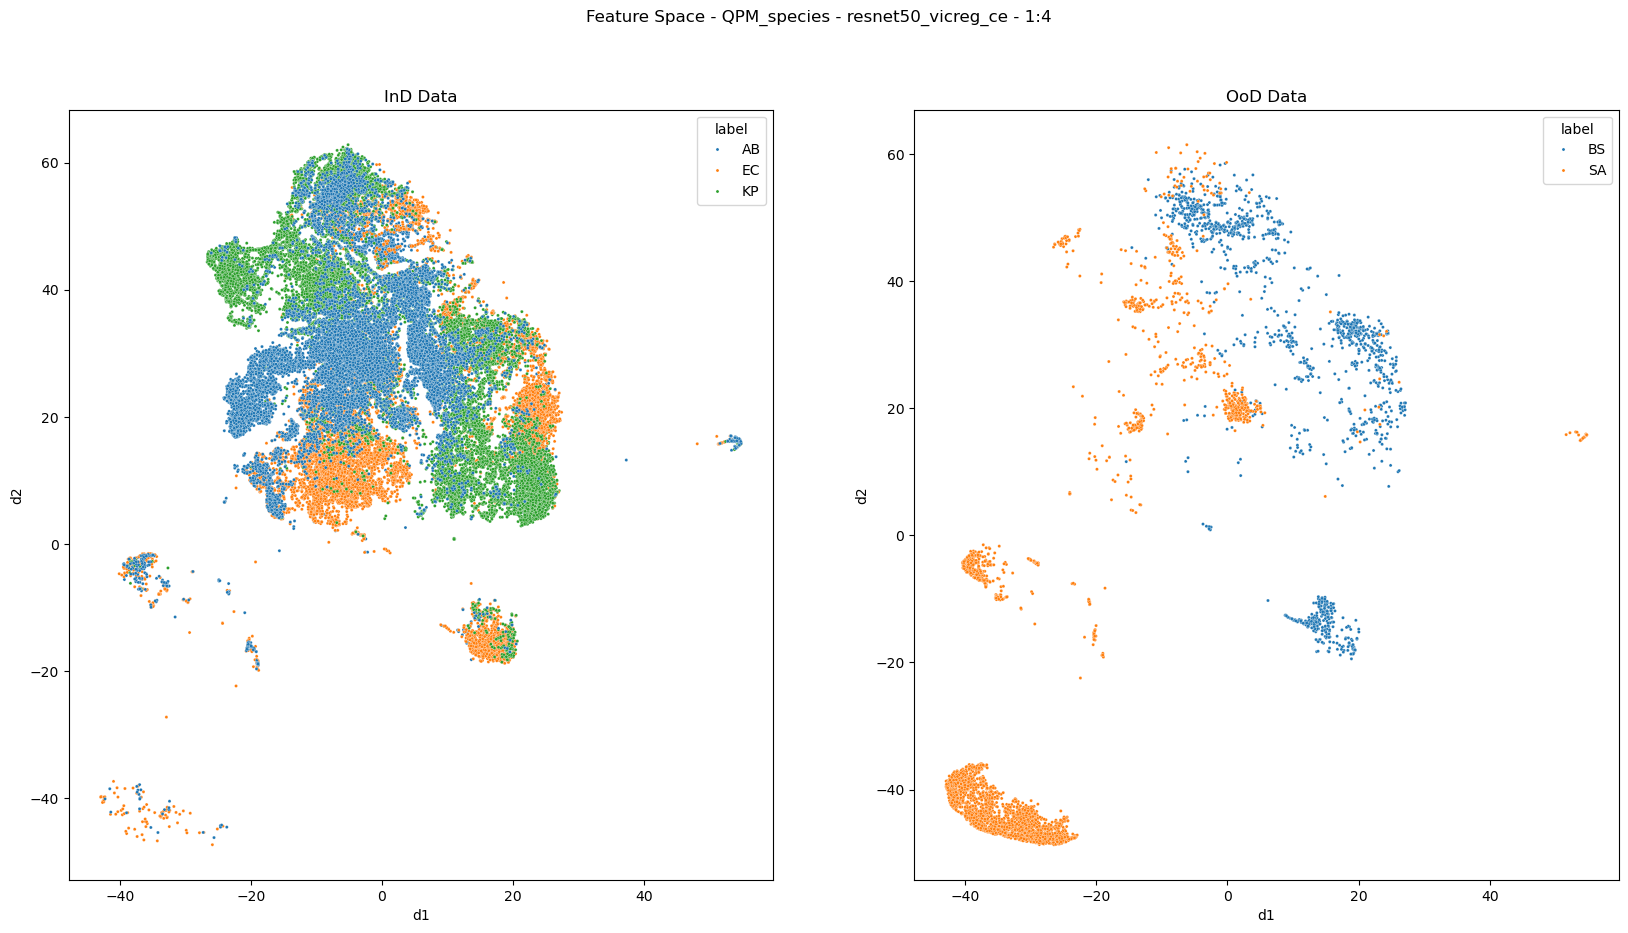

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

ftr_data = pd.DataFrame()
d1, d2 = ind_ftr2d.T
ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_ftr2d.T
    ftr_data = pd.concat([ftr_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=ftr_data[(ftr_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

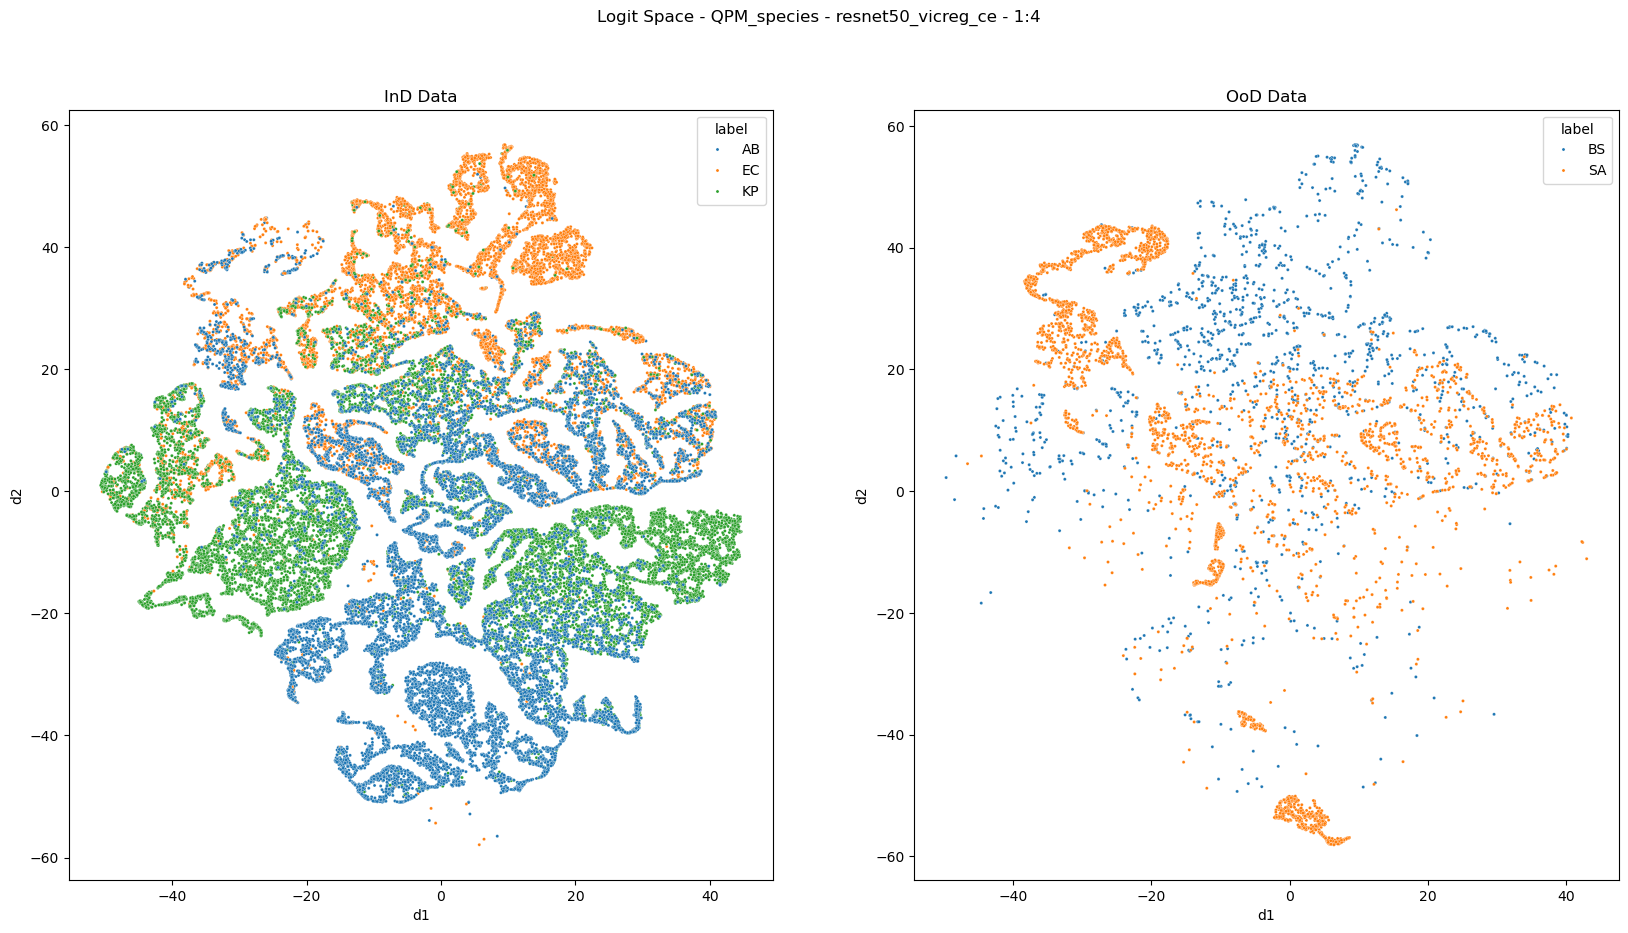

In [14]:
lgt_data = pd.DataFrame()
d1, d2 = ind_lgt2d.T
lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt2d.T
    lgt_data = pd.concat([lgt_data, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=lgt_data[(lgt_data['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:49<02:27, 49.32s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:38<01:38, 49.36s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:29<00:49, 49.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:22<00:00, 51.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:22<00:00, 50.57s/it]

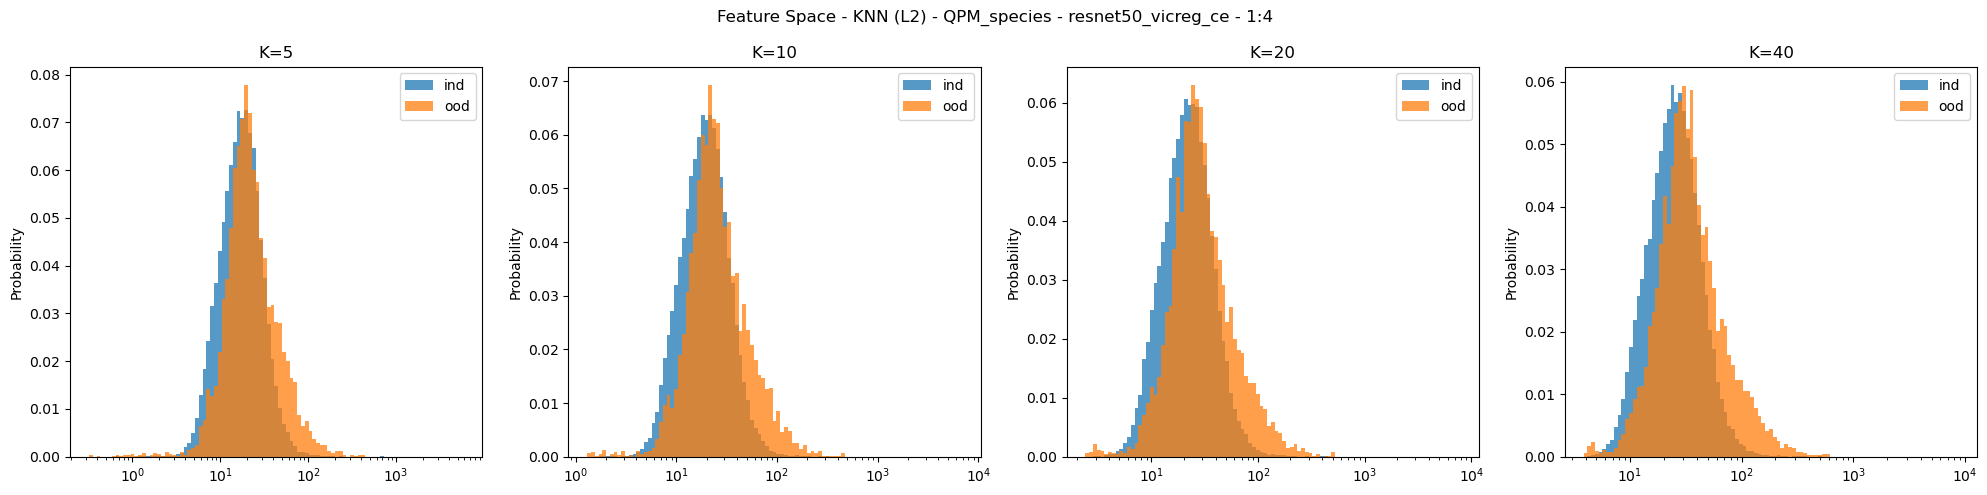

In [15]:
import faiss

index_ftr = faiss.IndexFlatL2(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:52<02:38, 52.80s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:42<01:41, 50.87s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:30<00:49, 49.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:18<00:00, 49.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:18<00:00, 49.71s/it]

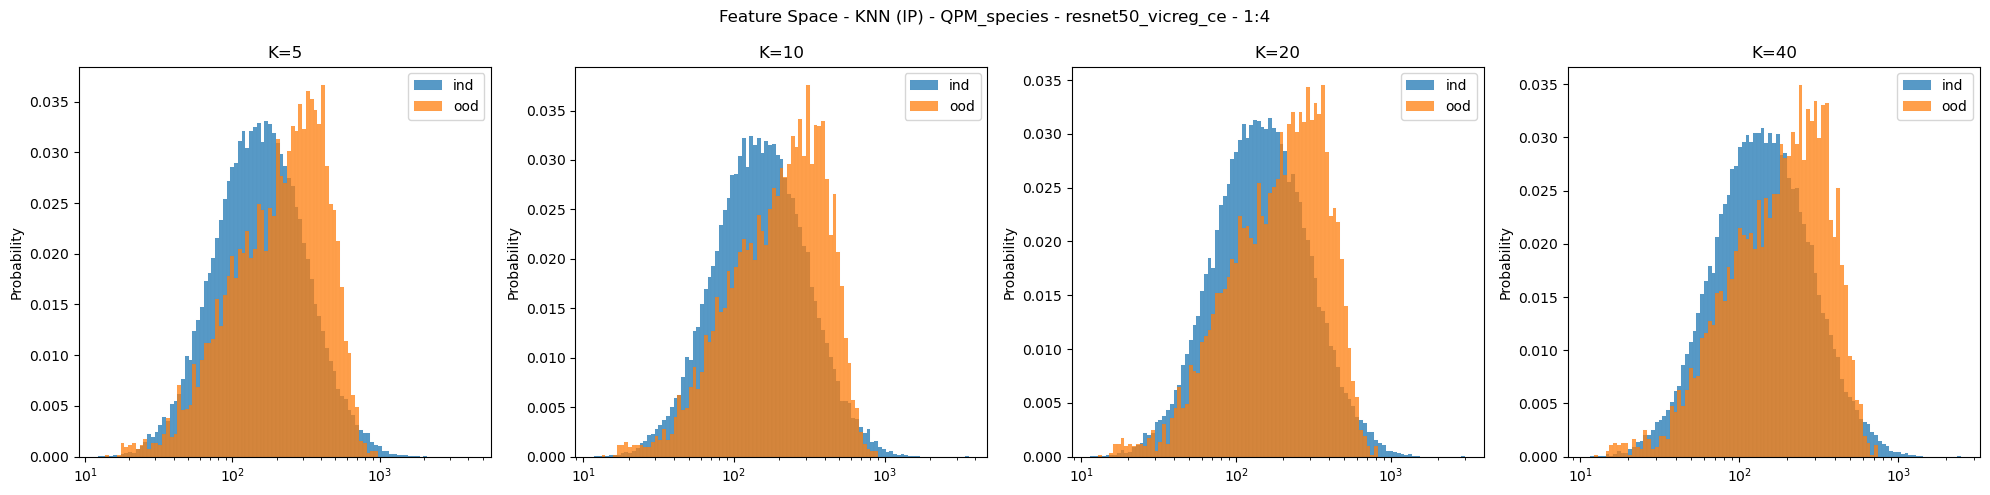

In [16]:
import faiss

index_ftr = faiss.IndexFlatIP(ind_ftr.shape[-1])
index_ftr.add(ind_ftr)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:47<02:23, 47.77s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:36<01:36, 48.46s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:26<00:48, 48.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:15<00:00, 48.92s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:15<00:00, 48.78s/it]

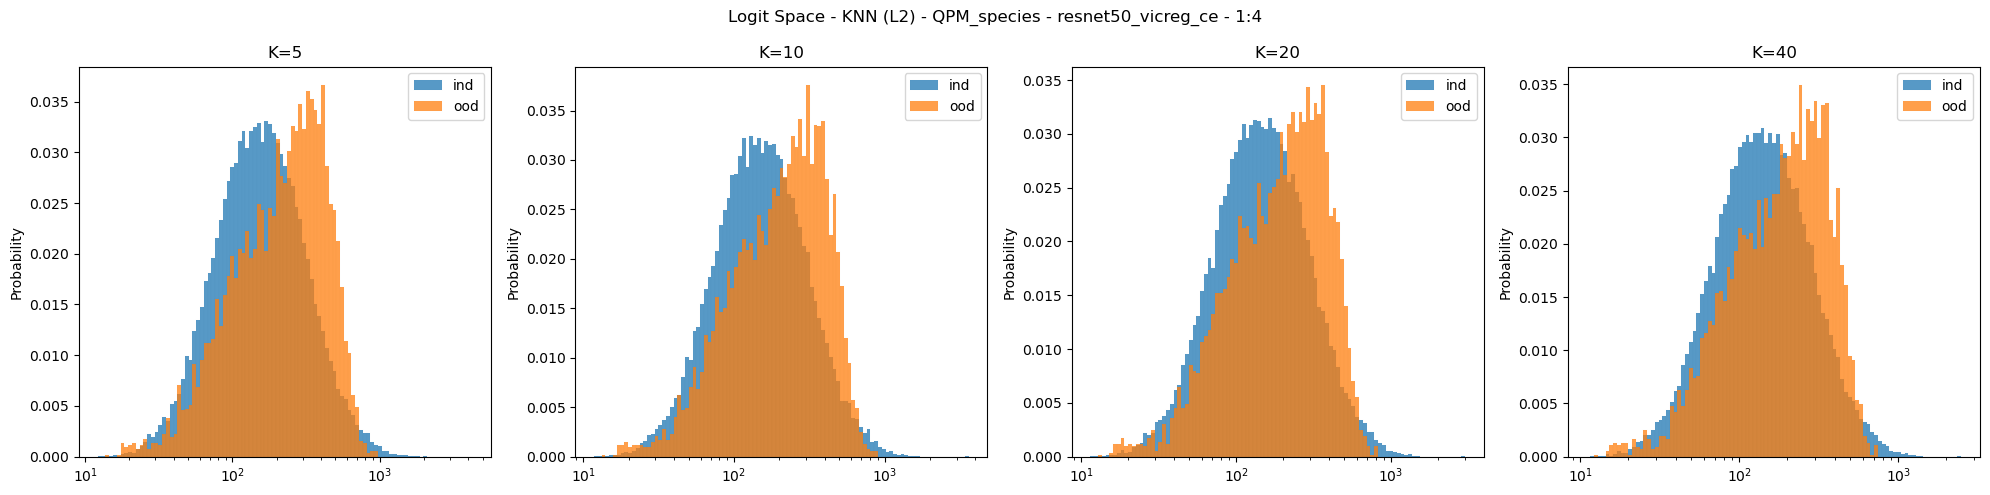

In [17]:
import faiss

index_lgt = faiss.IndexFlatL2(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

 25%|████████████████████████████████████████████                                                                                                                                    | 1/4 [00:47<02:22, 47.41s/it]

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 2/4 [01:34<01:35, 47.50s/it]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3/4 [02:22<00:47, 47.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:10<00:00, 47.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:10<00:00, 47.73s/it]

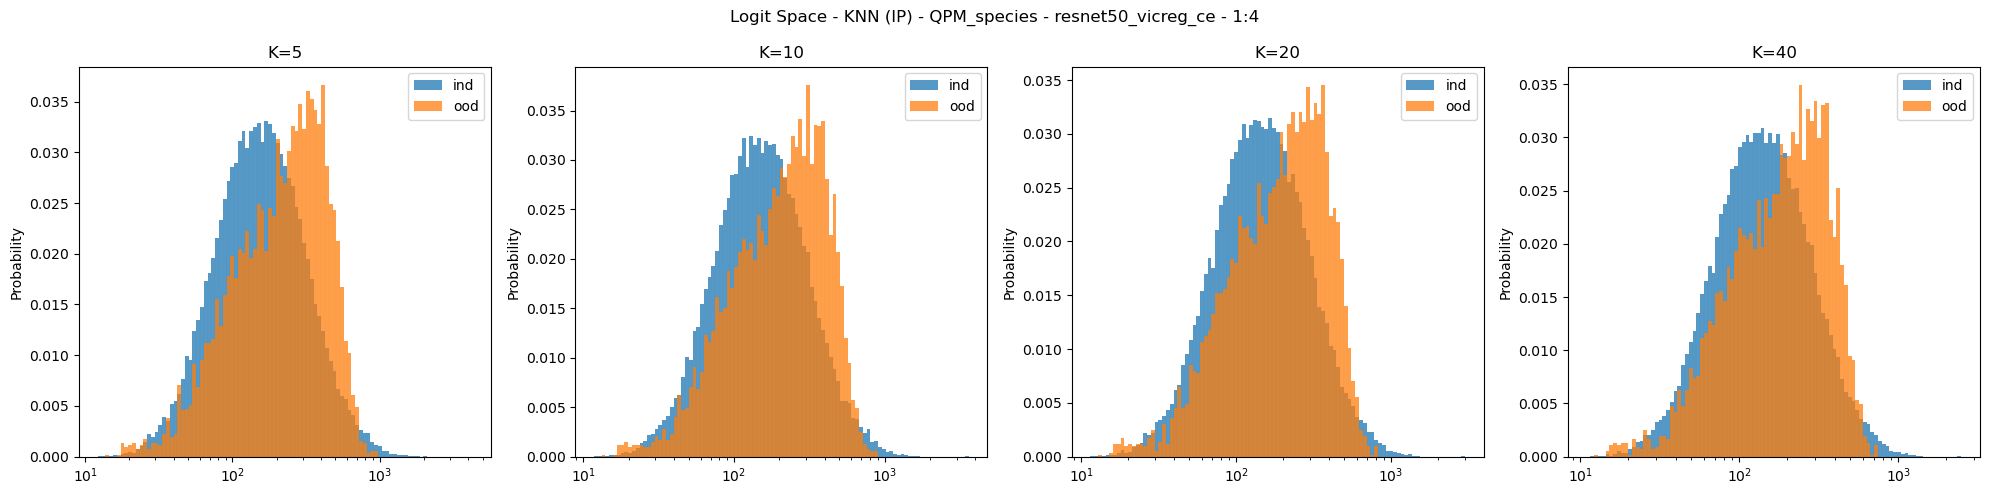

In [18]:
import faiss

index_lgt = faiss.IndexFlatIP(ind_lgt.shape[-1])
index_lgt.add(ind_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_ftr.search(ind_ftr, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_ftr.search(ood_ftr, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

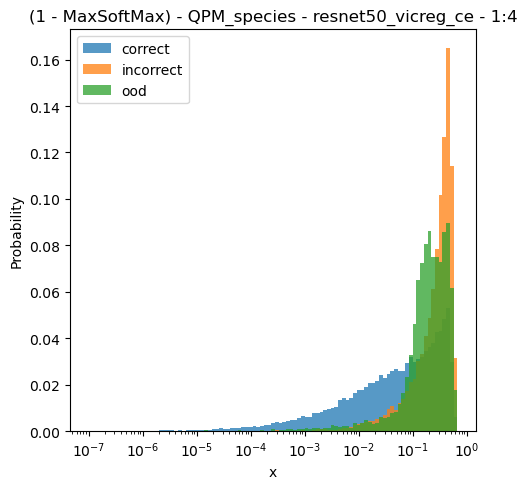

In [19]:
ind_prob = np.exp(ind_lgt) / np.exp(ind_lgt).sum(-1, keepdims=True)
ind_pred = ind_prob.argmax(-1)
ind_ucty = -ind_prob.max(-1) + 1.0

if ood_str:
    ood_prob = np.exp(ood_lgt) / np.exp(ood_lgt).sum(-1, keepdims=True)
    ood_pred = ood_prob.argmax(-1)
    ood_ucty = -ood_prob.max(-1) + 1.0

df_t = pd.DataFrame({"x": ind_ucty[ind_pred == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty[ind_pred != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.logspace(np.log10(df['x'].min() + 1e-7), np.log10(df['x'].max()), 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
ax.set_xscale("log")
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()